# Capstone: Customer Demand Forecasting

**Notebook 4.2 - Contents**<br>
[Data Import](#Data-Import)<br>
[Function for Visualisation](#Function-for-Visualisation)<br>
[Features Creation](#Features-Creation)<br>
[Features Selection](#Features-Selection)<br>
[Train Test Split](#Train-Test-Split)<br>
[Random Forest Model](#Random-Forest-Regression-Model)<br>
[Evaluate Model](#Evaluate-Model)<br>
[Feature Importance](#Feature-Importance)<br>
[XGBoost Model](#XGBoost-Model)<br>
[Model Comparison](#Model-Comparison)<br>

In [1]:
# !pip install xgboost

## Data Import

Import Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import math

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

import xgboost as xgb

Import Dataframe that was set up with X features and resampled and reindex during ARIMAX/SARIMAX modeling.

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
mobiles_df = pickle.load(open('../pkl/mobiles_sales_exog.pkl', 'rb'))

In [5]:
mobiles_df

,order_qty,price,discount_amount,payment_method,full_name,gender,age,state,region
2020-10-01,46,233.673684,7.368421,cod,"Starkey, Stephan",F,42.473684,CA,South
2020-10-02,65,176.762069,5.265034,cod,"Guillaume, Alton",F,43.620690,NY,Midwest
2020-10-03,140,834.051923,279.100192,cod,"Agin, Winona",M,44.519231,CA,South
2020-10-04,34,388.966667,187.574417,cod,"Clausing, Rafael",M,47.583333,CA,South
2020-10-05,32,461.153846,221.538462,cod,"Gratton, Raul",F,46.692308,CA,South
...,...,...,...,...,...,...,...,...,...
2021-09-26,2,150.000000,0.000000,cod,"Crimmins, Lauren",M,62.000000,KY,South
2021-09-27,2,150.000000,0.000000,cod,"Crimmins, Lauren",M,62.000000,KY,South
2021-09-28,2,150.000000,0.000000,cod,"Crimmins, Lauren",M,62.000000,KY,South
2021-09-29,2,150.000000,0.000000,cod,"Crimmins, Lauren",M,62.000000,KY,South


Check for nulls before train test split

In [6]:
mobiles_df.isnull().sum()

order_qty          0
price              0
discount_amount    0
payment_method     0
full_name          0
gender             0
age                0
state              0
region             0
dtype: int64

## Function for Visualisation

In [7]:
def plot_forecast(y_train, y_test, model, period, X_train, X_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test[:period])
    rmse_train= np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test[:period], y_pred_test))
    
    plt.figure(figsize=(20,6))
    plt.plot(y_train, color='cornflowerblue', label='y_train')
    plt.plot(y_test, color='orange', label='y_test', alpha = 0.7)
    plt.plot(X_train.index, y_pred_train, color='green', alpha = 0.9, ls = '--')
    plt.plot(X_test[:period].index, y_pred_test, color='green', label='y_pred', alpha = 0.9, ls = '--')
    
    plt.xlabel('Period')
    plt.ylabel('Sales Quantity')
    plt.title(label = f'Mobiles & Tablets - Sales Quantity Predictions\n\n Train RMSE:{rmse_train:.2f};  Test RMSE: {rmse_test:.2f}', fontsize=12)
    plt.legend(fontsize = 9, loc = 'upper left'); 

## Features Creation

From EDA, we noticed that day of week and week in month play a significant role in order quantity increase hence these features are created for regression modelling. 

In [8]:
# for mapping of day of the week and month to their corresponding name
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Extract day of week from datetime index
mobiles_df['day_of_week'] = mobiles_df.index.dayofweek
mobiles_df['day_of_week'] = mobiles_df['day_of_week'].apply(lambda x: weekday_names[x])

# Extract week in month from datetime index
mobiles_df['week_in_month'] = mobiles_df.index.day/7
mobiles_df['week_in_month'] = mobiles_df['week_in_month'].apply(lambda x: math.ceil(x)).astype(str)

In [9]:
# Check results
mobiles_df

,order_qty,price,discount_amount,payment_method,full_name,gender,age,state,region,day_of_week,week_in_month
2020-10-01,46,233.673684,7.368421,cod,"Starkey, Stephan",F,42.473684,CA,South,Thursday,1
2020-10-02,65,176.762069,5.265034,cod,"Guillaume, Alton",F,43.620690,NY,Midwest,Friday,1
2020-10-03,140,834.051923,279.100192,cod,"Agin, Winona",M,44.519231,CA,South,Saturday,1
2020-10-04,34,388.966667,187.574417,cod,"Clausing, Rafael",M,47.583333,CA,South,Sunday,1
2020-10-05,32,461.153846,221.538462,cod,"Gratton, Raul",F,46.692308,CA,South,Monday,1
...,...,...,...,...,...,...,...,...,...,...,...
2021-09-26,2,150.000000,0.000000,cod,"Crimmins, Lauren",M,62.000000,KY,South,Sunday,4
2021-09-27,2,150.000000,0.000000,cod,"Crimmins, Lauren",M,62.000000,KY,South,Monday,4
2021-09-28,2,150.000000,0.000000,cod,"Crimmins, Lauren",M,62.000000,KY,South,Tuesday,4
2021-09-29,2,150.000000,0.000000,cod,"Crimmins, Lauren",M,62.000000,KY,South,Wednesday,5


In [10]:
mobiles_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2020-10-01 to 2021-09-30
Freq: D
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   order_qty        365 non-null    int64  
 1   price            365 non-null    float64
 2   discount_amount  365 non-null    float64
 3   payment_method   365 non-null    object 
 4   full_name        365 non-null    object 
 5   gender           365 non-null    object 
 6   age              365 non-null    float64
 7   state            365 non-null    object 
 8   region           365 non-null    object 
 9   day_of_week      365 non-null    object 
 10  week_in_month    365 non-null    object 
dtypes: float64(3), int64(1), object(7)
memory usage: 34.2+ KB


Filtered the data to cut off at 2021-06-30 per time series modeling to enable comparison

In [11]:
mobiles_df = mobiles_df[mobiles_df.index<='2021-06-30']
mobiles_df

,order_qty,price,discount_amount,payment_method,full_name,gender,age,state,region,day_of_week,week_in_month
2020-10-01,46,233.673684,7.368421,cod,"Starkey, Stephan",F,42.473684,CA,South,Thursday,1
2020-10-02,65,176.762069,5.265034,cod,"Guillaume, Alton",F,43.620690,NY,Midwest,Friday,1
2020-10-03,140,834.051923,279.100192,cod,"Agin, Winona",M,44.519231,CA,South,Saturday,1
2020-10-04,34,388.966667,187.574417,cod,"Clausing, Rafael",M,47.583333,CA,South,Sunday,1
2020-10-05,32,461.153846,221.538462,cod,"Gratton, Raul",F,46.692308,CA,South,Monday,1
...,...,...,...,...,...,...,...,...,...,...,...
2021-06-26,0,1749.900000,0.000000,cod,"Leeson, Nakia",F,25.000000,AZ,West,Saturday,4
2021-06-27,6,6017.533333,0.000000,customercredit,"Pedrosa, Haydee",F,37.000000,MO,Midwest,Sunday,4
2021-06-28,0,6017.533333,0.000000,customercredit,"Pedrosa, Haydee",F,37.000000,MO,Midwest,Monday,4
2021-06-29,6,59.900000,0.000000,cod,"Funches, Raymond",M,54.000000,VA,South,Tuesday,5


## Features Selection 

- During first few trials on modelling, the results were overfitting hence decided to exclude noisy features like customer 'full_name' as there are too many unique number.
- 'gender' is also removed from modelling because it does not rank high in feature importance.
- The model results improved once these features are removed from modelling. 

In [37]:
# display proportion of gender
mobiles_df['gender'].value_counts()

F    169
M    104
Name: gender, dtype: int64

In [38]:
# display unique value of 'full name'
mobiles_df['full_name'].unique()

array(['Starkey, Stephan', 'Guillaume, Alton', 'Agin, Winona',
       'Clausing, Rafael', 'Gratton, Raul', 'Adelson, Verline',
       'Herrin, Fidela', 'Crader, Tad', 'Shapiro, Nichelle',
       'Bonnette, Delilah', 'Earle, Brad', 'Rue, Miguel',
       'Pendleton, Mauro', 'Mulloy, Jaclyn', 'Smalling, Kizzy',
       'Genovese, Harley', 'Swindell, Myrle', 'Bobo, Alyse',
       'Eshleman, Lennie', 'Boatner, Reyna', 'Byers, Alfred',
       'Ulm, Madeleine', 'Anstett, Emogene', 'Cimino, Arturo',
       'Ballantyne, Elvie', 'Cordell, Leon', 'Champ, Kendrick',
       'Junker, Maybell', 'Buckman, Chau', 'Seltzer, Earl',
       'Dickman, Song', 'Niblett, Sheri', 'Bolanos, Kerri',
       'Friesen, Setsuko', 'Badillo, Wilburn', 'Paulus, Delicia',
       'Keele, Carita', 'Alsop, Felicia', 'Costigan, Roberto', 'Bay, Kip',
       'Bean, Gemma', 'Dehaan, Kylee', 'Grado, Hattie', 'Chang, Rickie',
       'Fells, Steffanie', 'Bolte, Joanne', 'Dimmick, Benita',
       'Morehead, Jean', 'Amaral, Perla', '

In [14]:
X = mobiles_df[['price','discount_amount','age','day_of_week','week_in_month','payment_method','region','state']]
y = mobiles_df[['order_qty']]

## Train Test Split

In [15]:
X_train = X[:182]
X_test = X[182:]
y_train = y[:182]
y_test = y[182:]

In [16]:
# Check the split is correct
print('X_train dataframe rows, columns: ', X_train.shape)
print('y_train rows: ', y_train.shape)
print('X_test dataframe rows, columns: ', X_test.shape)
print('y_test rows: ', y_test.shape)

X_train dataframe rows, columns:  (182, 8)
y_train rows:  (182, 1)
X_test dataframe rows, columns:  (91, 8)
y_test rows:  (91, 1)


In [17]:
# Check split datetime
y_train.index, y_test.index

(DatetimeIndex(['2020-10-01', '2020-10-02', '2020-10-03', '2020-10-04',
                '2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08',
                '2020-10-09', '2020-10-10',
                ...
                '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25',
                '2021-03-26', '2021-03-27', '2021-03-28', '2021-03-29',
                '2021-03-30', '2021-03-31'],
               dtype='datetime64[ns]', length=182, freq='D'),
 DatetimeIndex(['2021-04-01', '2021-04-02', '2021-04-03', '2021-04-04',
                '2021-04-05', '2021-04-06', '2021-04-07', '2021-04-08',
                '2021-04-09', '2021-04-10', '2021-04-11', '2021-04-12',
                '2021-04-13', '2021-04-14', '2021-04-15', '2021-04-16',
                '2021-04-17', '2021-04-18', '2021-04-19', '2021-04-20',
                '2021-04-21', '2021-04-22', '2021-04-23', '2021-04-24',
                '2021-04-25', '2021-04-26', '2021-04-27', '2021-04-28',
                '2021-04-29', '2021-0

## Random Forest Model

1. Random Forest model is an ensemble of decision tree algorithms that can be used for classification and regression problems.
2. In this model, bootstrap aggregation (bagging) creates a number of decision trees samples with replacement.  Some variables will appear more than once in sample.
3. Random forest select a subset of input features (columns) at each split point to construct decision trees. 
4. Each decision tree is unpruned and slightly overfits to make prediction errors from each tree unique and less correlated.
5. The final prediction is averaged across all decision trees resulting in better performance than bagged decision tree models.
6. Random Forest model can capture complex relationships in dataset and they are robust for short-term forecasts. 

Create the list for categorical and numerical for the selected features respectively for the transformers

In [18]:
categorical_col = ['day_of_week','week_in_month','payment_method','state','region']
numerical_col = ['price','discount_amount','age']

Create transformers

In [19]:
preprocessor = ColumnTransformer(
    transformers=[('ohe', OneHotEncoder(handle_unknown='infrequent_if_exist',drop='first',min_frequency=0.01), categorical_col),
                  ('ss', StandardScaler(), numerical_col)
                 ])

Create Pipeline for transformers and estimator

In [20]:
pipe_rf = Pipeline([('pp', preprocessor),
                    ('rf', RandomForestRegressor())])

Setting up parameters for model

In [21]:
pipe_rf_params = {'rf__max_depth': [3, 5, 7],    # no. of split each decision tree is allowed to make. 
                  'rf__n_estimators':[5, 10],    # no. of decision trees
                  'rf__max_samples':[0.3, 0.5, 0.8],  # max no. of rows that can be passed to each decision tree
                  'rf__min_samples_split':[3],
                  'rf__min_samples_leaf':[2],
                  'rf__random_state': [42]}

GridSearch based on parameters

In [22]:
gs_rf  = GridSearchCV(pipe_rf,
                      param_grid=pipe_rf_params,
                      cv=3)

Fit train data into GridSearch Random Foreast Model

In [23]:
gs_rf = gs_rf.fit(X_train, y_train.values.ravel())

C:\Users\chloe\mambaforge\envs\dsi-sg\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\chloe\mambaforge\envs\dsi-sg\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\chloe\mambaforge\envs\dsi-sg\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\chloe\mambaforge\envs\dsi-sg\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\chloe\mambaforge\envs\dsi-sg\lib\

### Evaluate Model

In [24]:
rf_result = pd.DataFrame(gs_rf.cv_results_).sort_values('rank_test_score',ascending=False)
rf_result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__max_depth,param_rf__max_samples,param_rf__min_samples_leaf,param_rf__min_samples_split,param_rf__n_estimators,param_rf__random_state,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,0.029066,0.010049,0.008531,0.006507,3,0.5,2,3,5,42,"{'rf__max_depth': 3, 'rf__max_samples': 0.5, '...",0.341749,0.498401,-4.226985,-1.128945,2.191578,18
14,0.026043,0.007366,0.005209,0.007366,7,0.5,2,3,5,42,"{'rf__max_depth': 7, 'rf__max_samples': 0.5, '...",0.504045,0.497885,-4.187883,-1.061985,2.210346,17
8,0.025932,0.007287,0.005341,0.007553,5,0.5,2,3,5,42,"{'rf__max_depth': 5, 'rf__max_samples': 0.5, '...",0.519520,0.498005,-3.994097,-0.992191,2.122687,16
0,0.039467,0.005859,0.011686,0.002954,3,0.3,2,3,5,42,"{'rf__max_depth': 3, 'rf__max_samples': 0.3, '...",0.119893,0.480062,-3.219867,-0.873304,1.665773,15
12,0.020835,0.007366,0.010418,0.007367,7,0.3,2,3,5,42,"{'rf__max_depth': 7, 'rf__max_samples': 0.3, '...",0.104932,0.480168,-3.073635,-0.829512,1.594212,14


Export model as pickle file

In [25]:
# pickle the model
pickle.dump(gs_rf, open('../pkl/randomforest_model.pkl', 'wb'))

### Visualization

Forecasting for next 91 days

C:\Users\chloe\mambaforge\envs\dsi-sg\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


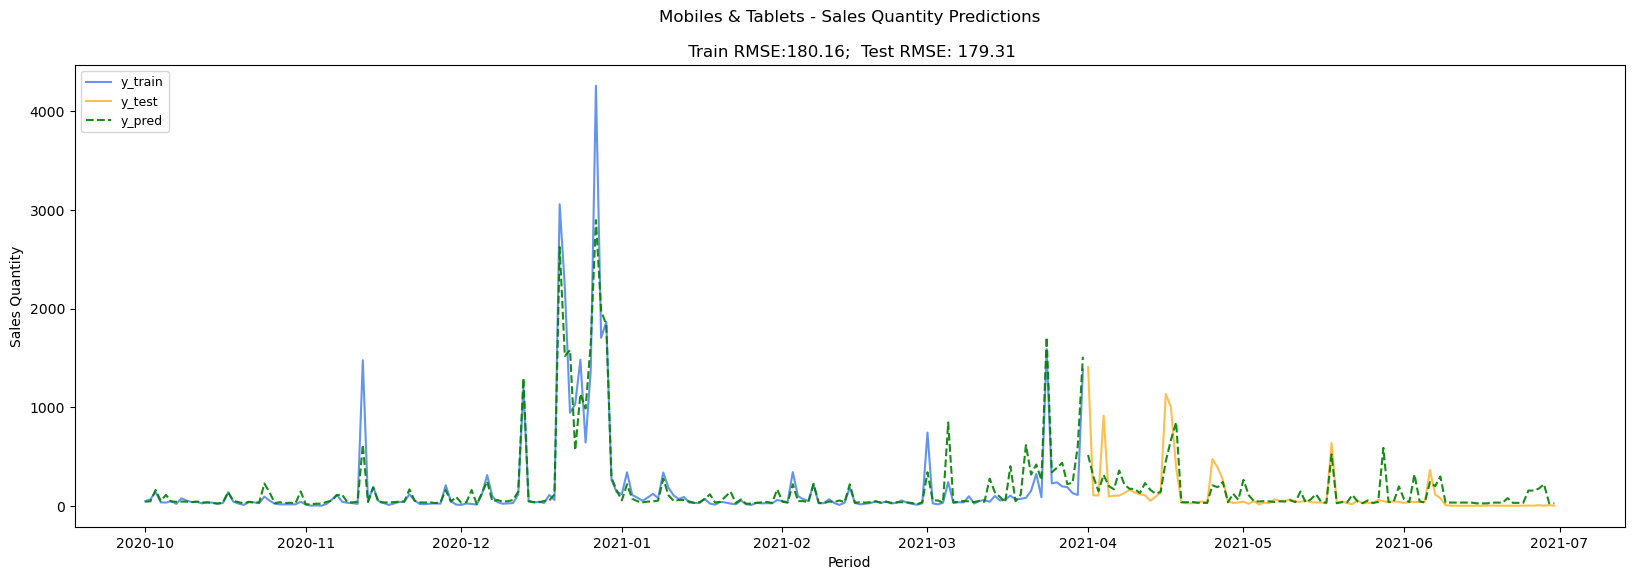

In [26]:
plot_forecast(y_train, y_test, gs_rf, 91, X_train, X_test)

### Feature Importance

Extract the model's feature importances based on Gini impurity

In [27]:
feature_importances = gs_rf.best_estimator_.named_steps['rf'].feature_importances_

Getting the feature names from best estimator

In [28]:
feature_names = gs_rf.best_estimator_.named_steps['pp'].get_feature_names_out()

Display the feature importances by most importance.

In [29]:
fi_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
fi_df.sort_values(by='importance', ascending=False, inplace=True)
fi_df.head(10)

,feature,importance
12,ohe__payment_method_easypay_voucher,0.605682
40,ss__discount_amount,0.203963
41,ss__age,0.089821
2,ohe__day_of_week_Sunday,0.049896
7,ohe__week_in_month_3,0.024299
39,ss__price,0.016016
5,ohe__day_of_week_Wednesday,0.004464
11,ohe__payment_method_cod,0.002929
16,ohe__state_CA,0.000867
0,ohe__day_of_week_Monday,0.000801


Findings from Random Forest model:
1. From the above line plot, it shows that the y_predicted and y_true are hugging together, indicating model is able to predict seasonality well.
2. Train RMSE and test RMSE is close to each other suggesting no overfitting issue. The RMSE is lower than time series SARIMAX model. 
3. Hyperparameter tuning enables fine-tuning for best results to ensure there are good fit model that generalize well to new data.
4. Hyperparameter tuning is powerful as by setting the right parameters, the results can improved tremendously.
5. Max_depth controls the number of splits of each decision tree.  The general thumb of rule for max_depth is 3, 5, or 7 so that to prevent the model from underfitting if no. of splits are too low, also avoiding overfitting if no. of splits are too high. 
6. Max_samples control the number of rows that are shown to each decision tree if bootstrap is true. This improved overfitting issue significantly. 
7. Feature importance shed lights on the important feature that drive demand. Payment method 'easypay voucher' appeared to be the strongest feature, followed by discount amount and age.  Week of day 'Sunday' and 3rd week of the month are also one of the top 5 important features.
8. Feature importance helps isolate noisy features 'full_name' and 'gender'.  The model results improved once these two features are removed from modelling.

## XGBoost Model

1. Extreme Gradient Boosting (XGBoost) refers to implementation of gradient boosting ensemble algorithm for classification and regression problems. It is a favourite predictive model among data scientists which can be used for time series forecasting under supervised machine learning. 
2. XGBoost uses a number of gradient boosted trees (referred to as n_estimators in the model) to predict the value of a dependent variable (in this case, sales demand). This is done through combining decision trees (which individually are weak learners) to form a combined strong learner.
3. In other words, new trees fix errors from the weak learners and then added until no further improvements can be made to the model (losses are minimized). Hence caution when setting the depth of trees as it is greedy algorithm that can overfit a training dataset quickly. 
4. The trees in Random Forest are independent and being trained in parallel, while gradient boosting trees are trained in sequence, one tree at a time, each to correct errors of previous one.
5. The maximum tree depth is defaulted to 3 and rarely needs to go higher than 5, as higher tree depth may lead to overfitting and memory consumption inefficiency. 
6. The learning rate (α) is multiplied by weight in every tree, showing an inverse relationship between learning rate and accuracy, hence a lower learning rate is chosen.
7. The minimum child weight regularizes by limiting the depth of trees, which means the larger the better.   

Create Pipeline for transformers and estimator

In [30]:
pipe_xgb = Pipeline([('pp', preprocessor),
                    ('xgb', xgb.XGBRegressor())])

Setting up parameters 

In [31]:
pipe_xgb_params = {'xgb__n_estimators': [50, 80], 
                   'xgb__learning_rate': [0.01, 0.05],
                   'xgb__subsample': [0.1, 0.3],
                   'xgb__colsample_bytree': [0.1, 0.3],
                   'xgb__max_depth': [3, 5],
                   'xgb__min_child_weight': [1, 3], 
                   'xgb__random_state' : [42]}

GridSearch based on parameters

In [32]:
gs_xgb  = GridSearchCV(pipe_xgb,
                       param_grid = pipe_xgb_params,
                       scoring = 'neg_mean_squared_error',
                       cv=3)

Fit into GridSearch XGBoost model

In [33]:
gs_xgb = gs_xgb.fit(X_train, y_train)

C:\Users\chloe\mambaforge\envs\dsi-sg\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\chloe\mambaforge\envs\dsi-sg\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\chloe\mambaforge\envs\dsi-sg\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\chloe\mambaforge\envs\dsi-sg\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\chloe\mambaforge\envs\dsi-sg\lib\

Export model as pickle file

In [34]:
# pickle the model
pickle.dump(gs_xgb, open('../pkl/xgboost_model.pkl', 'wb'))

### Evaluate Model

In [35]:
rf_result2 = pd.DataFrame(gs_xgb.cv_results_).sort_values('rank_test_score',ascending=False)
rf_result2.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__colsample_bytree,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_weight,param_xgb__n_estimators,param_xgb__random_state,param_xgb__subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
4,0.035271,0.009580,0.012093,0.003112,0.1,0.01,3,3,50,42,0.1,"{'xgb__colsample_bytree': 0.1, 'xgb__learning_...",-60928.947929,-704728.031985,-74698.280572,-280118.420162,300296.953553,63
12,0.035726,0.003473,0.011023,0.007811,0.1,0.01,5,3,50,42,0.1,"{'xgb__colsample_bytree': 0.1, 'xgb__learning_...",-60928.947929,-704728.031985,-74698.280572,-280118.420162,300296.953553,63
8,0.032492,0.005141,0.008715,0.006505,0.1,0.01,5,1,50,42,0.1,"{'xgb__colsample_bytree': 0.1, 'xgb__learning_...",-60807.499625,-706582.357715,-66942.910437,-278110.922592,302985.410929,62
0,0.048099,0.007239,0.010667,0.007547,0.1,0.01,3,1,50,42,0.1,"{'xgb__colsample_bytree': 0.1, 'xgb__learning_...",-60834.666928,-706070.587140,-66982.354387,-277962.536152,302728.509841,61
6,0.041634,0.007339,0.015778,0.000212,0.1,0.01,3,3,80,42,0.1,"{'xgb__colsample_bytree': 0.1, 'xgb__learning_...",-55686.101404,-698806.984663,-70501.235625,-274998.107231,299739.159374,60


### Visualisation

Forecasting for next 91 days

C:\Users\chloe\mambaforge\envs\dsi-sg\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


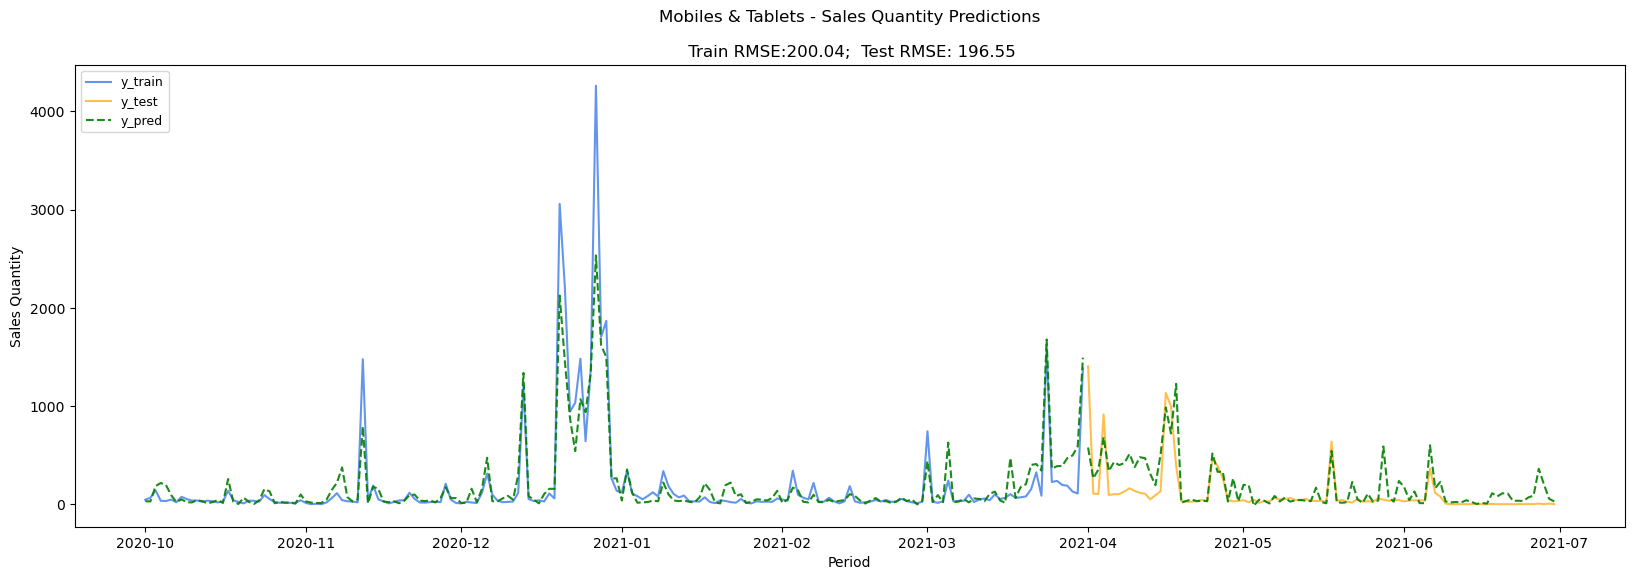

In [36]:
plot_forecast(y_train, y_test, gs_xgb, 91, X_train, X_test)

Findings from XGBoost model:
1. The above line plot between y_predicted and y_true are quite hugging together, indicating model is able to predict seasonality pretty well.2. 
Train RMSE and test RMSE is close to each othe,r sugges that there isg no overfitting issue. The RMSE is lower than time series SARIMAX mode, but higher than Random Forest model.

## Model Comparison

- Based on analysis and comparison of the 6 models, Random Forest Regression yields lowest RMSE on test data and is a good fit model hence it is our best model. 
- Incorporating exogenous factors into modelling help contributed to lower RMSE.
- Random Forest Regressor handle complexity better through hyperparamter tuning and generalize to new data better than time series models.

| Models                 | RMSE                   | Review           |
|------------------------|------------------------|------------------|
| ARIMA                  | Train: 430; Test: 247  | Massively overfits. Baseline model   |    
| ARIMAX                 | Train: 273; Test: 198  | Relatively overfits|
| SARIMA                 | Train: 388; Test: 260  | Massively overfits|
| SARIMAX                | Train: 262; Test: 196  | Relatively overfits|
| Random Forest          | Train: 180; Test: 179  | Good fit. Lowest RMSE. **Best Model**    |   
| XGBoost                | Train: 200; Test: 197  | Good fit.   |